## Imports

In [14]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


import numpy as np
from sklearn import datasets
from JOPLEn.singletask import JOPLEn
from JOPLEn.enums import *
from sklearn.ensemble import (
    ExtraTreesRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.linear_model import LinearRegression
from lineartree import (
    LinearForestRegressor,
    LinearBoostRegressor,
)
from JOPLEn.ablation import Booster
import lineartree as lt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor, DummyClassifier
from itertools import product
import warnings
from collections import defaultdict
from linear_operator.utils.warnings import NumericalWarning
from sklearn.linear_model import Ridge

# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)
# Ax gives warning about non PSD matrix.
# TODO: Should I fix this?
warnings.simplefilter(action="ignore", category=NumericalWarning)
from ax import optimize
from pathlib import Path
from copy import copy, deepcopy
import yaml
import time
from pprint import pprint
from ax.service.ax_client import AxClient, ObjectiveProperties
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER
from JOPLEn.partitioner import (
    VPartition,
    GBPartition,
    RFPartition,
    VarMaxForestPartition,
    LinearForestPartition,
    LinearBoostPartition,
)
from JOPLEn.enums import CellModel
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from nn import NN

import sys

fastel_path = Path().resolve().parent
sys.path.append(str(fastel_path))

from FASTEL.src.engine import MultiTaskTrees

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)

CACHE_DIR = Path("ax_runs") / "prediction"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = Path("..") / "datasets" / "pmlb" / "processed"
PARAM_PATH = Path(".") / "parameters"
PLOT_PATH = Path(".") / "plots"

In [15]:
# too many samples, causes JOPLEn to crash
EXCLUDE = [
    "1191_BNG_pbc",
    "215_2dplanes",
    "1201_BNG_breastTumor",
    "1196_BNG_pharynx",
    "1595_poker",
    "1203_BNG_pwLinear",
    "594_fri_c2_100_5",
    "218_house_8L",
    "1193_BNG_lowbwt",
    "537_houses",
    "564_fried",
    "344_mv",
    "574_house_16H",
    "573_cpu_act",
    "562_cpu_small",
    "1199_BNG_echoMonths",
    "294_satellite_image",
    "197_cpu_act",
    "201_pol",
    "227_cpu_small",
    "503_wind",
    # # 10000 estimators
    # "225_puma8NH",
    # "529_pollen",
    # "622_fri_c2_1000_50",
    # "banana",
]

## Parameters

In [16]:
model_info = {}

for file in PARAM_PATH.glob("*.yaml"):
    model_info[file.stem] = yaml.safe_load(open(file, "r"))

## Training Functions

In [17]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        return (result, start_time, end_time, elapsed_time)

    return wrapper


@timer_decorator
def train_lgbm(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    model = LGBMRegressor(**params)
    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        # verbose=-1,
        callbacks=[],
    )

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model, {}
    else:
        return val_error, model


@timer_decorator
def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    rescale=False,
):
    if rescale:
        model = Pipeline(
            [("scaler", StandardScaler()), ("model", ModelClass(**params))]
        )
    else:
        model = ModelClass(**params)
    model.fit(x_train, y_train.flatten())

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model, {}
    else:
        return val_error, model


def train_gbr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        GradientBoostingRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_rfr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        RandomForestRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_etr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        ExtraTreesRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_abr(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        AdaboostRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_lb(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        LinearBoostRegressor,
        {**params, "base_estimator": LinearRegression()},
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_lf(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        LinearForestRegressor,
        {**params, "base_estimator": LinearRegression()},
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_ridge(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_sklearn(
        Ridge,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        rescale=True,
    )


@timer_decorator
def train_pen(
    ModelType,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    params = deepcopy(params)

    initial_params = {
        "partitioner": eval(params.pop("partitioner")),
        "n_cells": params.pop("n_cells"),
        "n_partitions": params.pop("n_partitions"),
        "random_state": params.pop("random_state"),
    }

    if "cell_model" in params:
        initial_params["cell_model"] = eval(params.pop("cell_model"))

    model = ModelType(**initial_params)

    if "norm_type" in params:
        params["norm_type"] = eval(params["norm_type"])

    history = model.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        **params,
    )

    val_error = float(rmse(y_val, model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test, model.predict(x_test)))
        return (
            val_error,
            test_error,
            model,
            {"n_epochs": len(history["objective"]) if "objective" in history else None},
        )
    else:
        return val_error, model


def train_joplen(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_pen(JOPLEn, params, x_train, y_train, x_val, y_val, x_test, y_test)


def train_booster(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    return train_pen(Booster, params, x_train, y_train, x_val, y_val, x_test, y_test)


@timer_decorator
def train_fastel(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    xs = StandardScaler().fit(x_train)
    ys = StandardScaler().fit(y_train.reshape(-1, 1))

    model = MultiTaskTrees(input_shape=x_train.shape[1:], **params)

    model.train(
        xs.transform(x_train),
        ys.transform(y_train.reshape(-1, 1)),
        np.ones((y_train.shape[0], 1)),
        xs.transform(x_val),
        ys.transform(y_val.reshape(-1, 1)),
        np.ones((y_val.shape[0], 1)),
    )

    y_val_pred = ys.inverse_transform(model.predict(xs.transform(x_val))[:, None])
    val_error = float(rmse(y_val, y_val_pred.flatten()))

    if x_test is not None and y_test is not None:
        y_test_pred = ys.inverse_transform(model.predict(xs.transform(x_test))[:, None])
        test_error = float(rmse(y_test, y_test_pred.flatten()))
        return val_error, test_error, model, {}
    else:
        return val_error, model


@timer_decorator
def train_nn(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    xs = StandardScaler().fit(x_train)

    tmp_params = deepcopy(params)

    model = NN(
        hidden_layer_size=tmp_params.pop("hidden_layer_size"),
        n_hidden_layers=tmp_params.pop("n_hidden_layers"),
        activation=tmp_params.pop("activation"),
        sel_feat=False,
    )
    model.fit(
        xs.transform(x_train),
        y_train,
        xs.transform(x_val),
        y_val,
        **tmp_params,
    )

    y_val_pred = model.predict(xs.transform(x_val))
    val_error = float(rmse(y_val, y_val_pred.flatten()))

    if x_test is not None and y_test is not None:
        y_test_pred = model.predict(xs.transform(x_test))
        test_error = float(rmse(y_test, y_test_pred.flatten()))
        return val_error, test_error, model, {}
    else:
        return val_error, model

In [18]:
def dummy_regressor(x_train, x_val, x_test, y_train, y_val, y_test, indent=False):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train)
    y_pred = dummy.predict(x_test)

    res = {
        "model_name": dummy.__class__.__name__,
        "rmse": float(rmse(y_test, y_pred)),
    }

    return res

## Run Experiments

In [19]:
def contains_categorical(arr: np.ndarray) -> bool:
    """Checks if an array contains categorical, ordinal, binary, or nominal features"""
    return np.any(np.all(np.mod(arr, 1) == 0, axis=0))


train_fn = {
    LGBMRegressor.__name__: train_lgbm,
    GradientBoostingRegressor.__name__: train_gbr,
    RandomForestRegressor.__name__: train_rfr,
    ExtraTreesRegressor.__name__: train_etr,
    JOPLEn.__name__: train_joplen,
    LinearBoostRegressor.__name__: train_lb,
    LinearForestRegressor.__name__: train_lf,
    Booster.__name__: train_booster,
    Ridge.__name__: train_ridge,
    MultiTaskTrees.__name__: train_fastel,
    NN.__name__: train_nn,
}


def optimize_model(
    model_info,
    ds_path,
    n_trials,
    minimize,
    loss_type,
    overwrite=False,
    skip_categorical=True,
):
    ds_name = ds_path.name
    params = model_info["parameters"]

    dir_path = CACHE_DIR / model_info["dir_name"] / ds_name
    exp_path = dir_path / "experiment.json"
    metadata_path = dir_path / "metadata.yaml"

    if metadata_path.exists() and not overwrite:
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    cell_model = [param["value"] for param in params if param["name"] == "cell_model"]
    if len(cell_model) > 0 and cell_model[0] == "CellModel.constant":
        is_constant_joplen = True
    else:
        is_constant_joplen = False

    parts = set(model_info["dir_name"].split("_"))

    if parts.intersection(["gb", "lgbm", "rf", "et"]):
        const_part = (len(parts) == 1) or is_constant_joplen
    else:
        const_part = False

    if contains_categorical(x_train) and skip_categorical:
        return None

    if contains_categorical(x_train) and not const_part:
        return None

    dummy_info = dummy_regressor(
        x_train, x_val, x_test, y_train, y_val, y_test, indent=True
    )

    if not exp_path.exists() or overwrite:
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=f"{model_info['model']}_{ds_name}",
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in trange(n_trials, leave=False, position=1):
            round_params, trial_index = ax_client.get_next_trial()

            try:
                val_error, _ = train_fn[model_info["model"]](
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                )[0]
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=float(val_error)
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(filepath=exp_path)

    best_parameters, values = ax_client.get_best_parameters()

    (val_error, test_error, _, metadata), _, _, train_time = train_fn[
        model_info["model"]
    ](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    metadata = {
        "model_name": model_info["model"],
        "val_score": float(val_error),
        "test_score": float(test_error),
        "train_time": float(train_time),
        "params": best_parameters,
        "dummy_loss": float(dummy_info["rmse"]),
        **metadata,
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata

In [29]:
ignored_models = [
    "joplen_linear_lingb_part",
    "joplen_linear_maxvar_part",
    "lb",
    # "joplen_const_gb_part_l2",
    # "joplen_const_gb_part_sl2",
    "joplen_const_gb_part_l1",
]

reg_datasets = [d for d in (DS_PATH / "reg").iterdir() if d.is_dir()]

reg_res = defaultdict(dict)

itr = tqdm(reg_datasets, position=0)

for ds_path in itr:
    if ds_path.name in EXCLUDE:
        continue

    for file_name, info in model_info.items():
        if "prediction" not in info["experiments"]:
            continue

        # if file_name not in ["joplen_const_gb_part", "gb", "joplen_linear_gb_part", "joplen_linear_linforest_part"]:
        #     continue

        if file_name in ignored_models:
            continue

        model_str = f"{file_name} on {ds_path.name}"
        itr.set_description(f"Running {model_str : <50}")
        res = optimize_model(info, ds_path, 50, False, "rmse", skip_categorical=False)

        if res is not None:
            reg_res[info["name"]][ds_path.name] = res

reg_res = dict(reg_res)

  0%|          | 0/122 [00:00<?, ?it/s]

In [30]:
models = [
    "JOPLEn (linear, GB partitions)",
    "JOPLEn (constant, RF partitions)",
    "JOPLEn (constant, GB partitions)",
    "JOPLEn (constant, GB partitions, l2)",
    "JOPLEn (constant, GB partitions, l2^2)",
    "JOPLEn (constant, GB partitions, l1)",
    "Linear forest",
    # 'JOPLEn (const 100)',
    "Random forest",
    "JOPLEn (linear, LinearForest partitions)",
    # 'JOPLEn (const greedy)',
    "Extra trees",
    "Gradient Boosting",
    "NN",
    "LightGBM",
    "JOPLEn (linear, RF partitions)",
    # 'JOPLEn (linear 100)',
    "JOPLEn (constant, LinearForest partitions)",
    "Ridge Regression",
    # 'Gradient Boosting (defaults)',
    "FASTEL",
]

# Only use datasets that are in reg_res["joplen_linear_gb_part"]
keys = [set(v.keys()) for k, v in reg_res.items() if k in models]
keys = set.intersection(*keys)
reg_res = {
    k: {kk: vv for kk, vv in v.items() if kk in keys}
    for k, v in reg_res.items()
    if k in models
}

{'Extra trees': 0.8455591861317283, 'Ridge Regression': 0.7660117178036178, 'FASTEL': 0.4745399925271502, 'Random forest': 0.47265745357207484, 'JOPLEn (constant, LinearForest partitions)': 0.4546480290904592, 'Linear forest': 0.40828207924533866, 'JOPLEn (linear, RF partitions)': 0.40199872824160854, 'LightGBM': 0.3885720388318063, 'JOPLEn (constant, RF partitions)': 0.38610208908374744, 'Gradient Boosting': 0.3511579485555469, 'NN': 0.3475355501700576, 'JOPLEn (linear, GB partitions)': 0.33148864687025437, 'JOPLEn (linear, LinearForest partitions)': 0.327422782850325, 'JOPLEn (constant, GB partitions, l2^2)': 0.3182653442184382, 'JOPLEn (constant, GB partitions)': 0.31751749380103816, 'JOPLEn (constant, GB partitions, l2)': 0.31518712690110895}


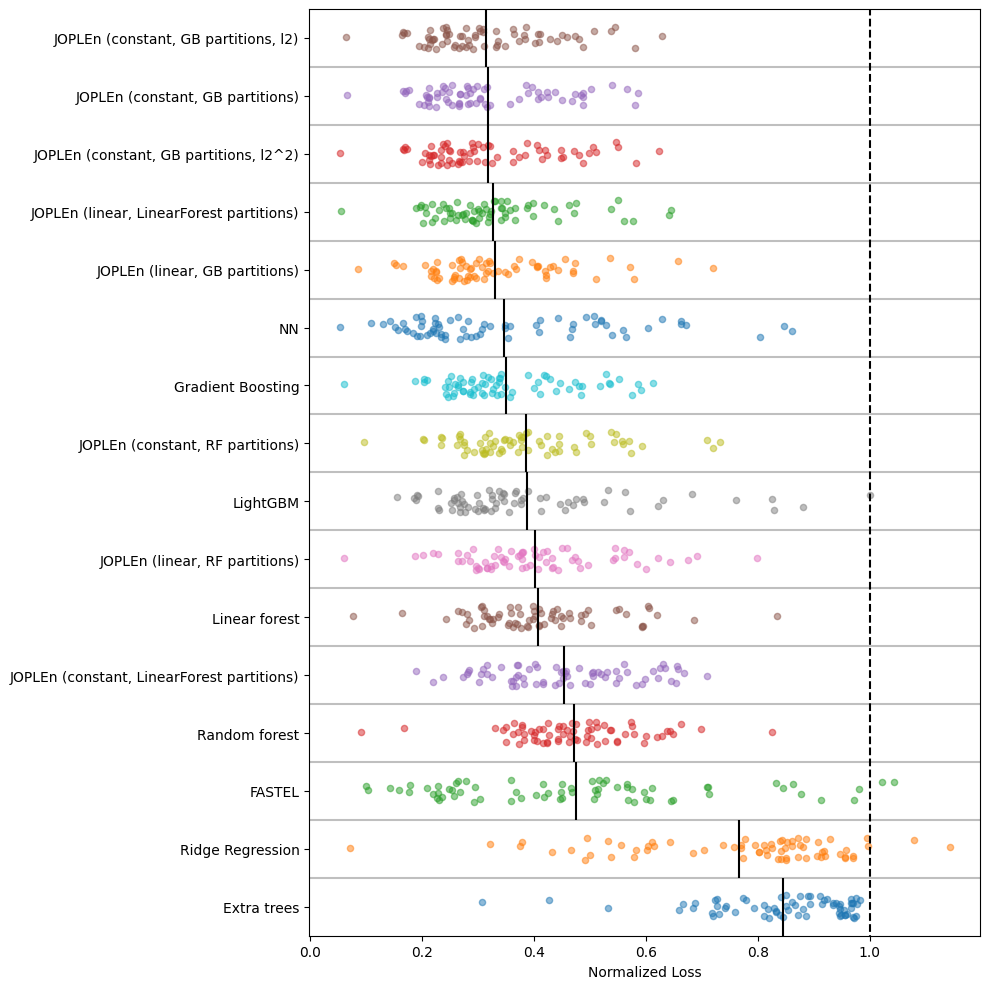

In [31]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
):
    """
    Create a strip plot based on the list of y-values.
    """
    fig, ax = plt.subplots(**plot_kwargs)

    for x_idx, x_values in enumerate(arr):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
        ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    # plot vertical line for mean for each model
    means = [np.mean(list(x_values)) for x_values in arr]
    for x_value, mean in zip(range(len(arr)), means):
        ax.vlines(mean, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    return ax, means


x_values = []
y_labels = []

# reg_res = {k: reg_res[k] for k in sorted(reg_res.keys())}
rescaled_res = {
    k: {kk: (vv["test_score"] / vv["dummy_loss"]) for kk, vv in v.items()}
    for k, v in reg_res.items()
}

mean_res = {k: np.mean(list(v.values())) for k, v in rescaled_res.items()}

sorted_dict = {k: rescaled_res[k] for k in sorted(mean_res, key=mean_res.get)[::-1]}

for k, v in sorted_dict.items():
    x_values.append(v.values())
    y_labels.append(k)

ax, means = plot_strip(
    x_values, plot_kwargs={"figsize": (10, 10)}, scatter_kwargs={"alpha": 0.5, "s": 20}
)

print({k: v for k, v in zip(y_labels, means)})

ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)

y_lim = ax.get_ylim()
ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")
ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

plt.xlabel("Normalized Loss")

plt.tight_layout()
plt.savefig(PLOT_PATH / "reg_strip.png", dpi=300)

plt.show()

In [23]:
# compute non-parametic distribution test
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

ours = np.array(list(rescaled_res["JOPLEn (constant, GB partitions, l2)"].values()))
theirs = np.array(list(rescaled_res["Gradient Boosting"].values()))

print(mannwhitneyu(ours, theirs, alternative="less"))
print(wilcoxon(ours, theirs, alternative="less"))

MannwhitneyuResult(statistic=4345.0, pvalue=0.034572290896945045)
WilcoxonResult(statistic=967.0, pvalue=2.532496584226348e-08)


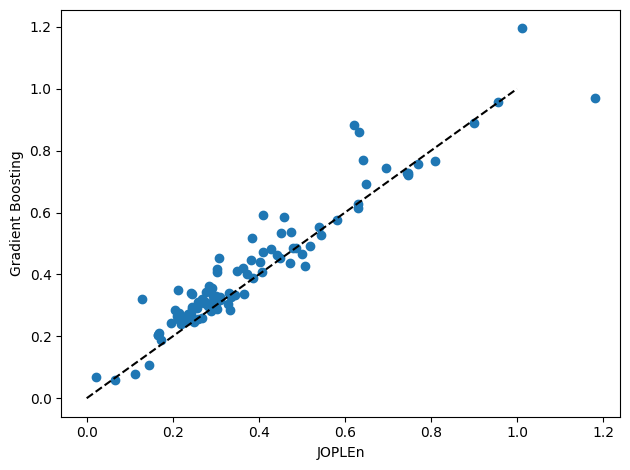

In [24]:
plt.scatter(ours, theirs)
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlabel("JOPLEn")
plt.ylabel("Gradient Boosting")
plt.tight_layout()
plt.show()

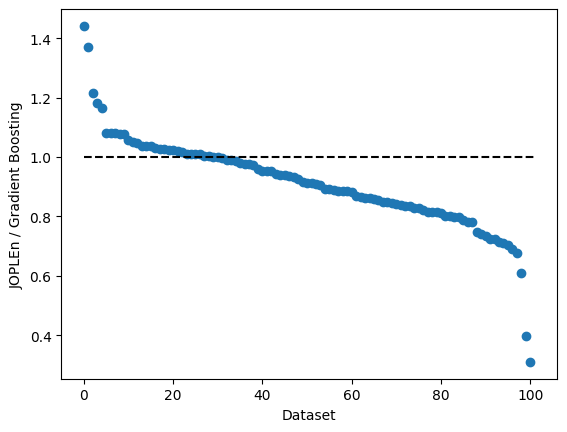

We do much worse on these datasets
['560_bodyfat', '527_analcatdata_election2000']


In [25]:
datasets = list(list(rescaled_res.values())[0].keys())

ratio = ours / theirs
args = np.argsort(ratio)[::-1]

plt.scatter(range(len(ratio)), ratio[args])
plt.hlines(1, 0, len(ratio), color="k", linestyle="--")

plt.xlabel("Dataset")
plt.ylabel("JOPLEn / Gradient Boosting")

plt.show()

print("We do much worse on these datasets")
print([datasets[i] for i in args[:2]])

- [192_vineyard](https://github.com/EpistasisLab/pmlb/blob/master/datasets/192_vineyard/metadata.yaml): Small dataset, 52 samples, 2 features. May be that we just needed to use a better GB model for selecting splits
- 645_fri_c3_500_50: Not sure what's wrong with this dataset

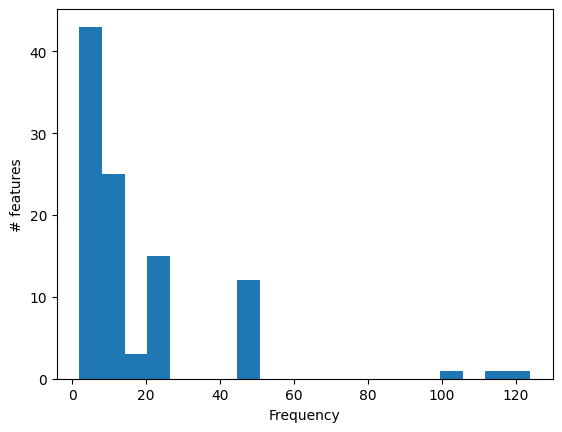

In [26]:
shapes = []

for ds_path in reg_datasets:
    if ds_path.name in EXCLUDE:
        continue

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    shapes.append(x_train.shape[1])

plt.hist(shapes, bins=20)
plt.ylabel("# features")
plt.xlabel("Frequency")
plt.show()